## 1) Import libraries

In [1]:
#import sys
#sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

import numpy as np
import pandas as pd

#from sklearn.externals import joblib

import re

import matplotlib.pyplot as plt
from scipy import sparse

import joblib

#Locate and list all xlms files so they can be opened all together

import os

xlms_files = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if filename[-4:]=='xlsm':  #Add to the list if the element's last four spaces form the word "xlsm"
            xlms_files += [filename]
        
xlms_files

['Rolls Royce Barnoldswick.xlsm',
 'Rolls Royce Derby EOS Rotatives.xlsm',
 'Rolls Royce Heathrow.xlsm',
 'Rolls Royce Jubilee House.xlsm',
 'Tag_50450069_Andover_Keens_House.xlsm',
 'Tag_50888200_Bristol_Canons_House.xlsm',
 'Tag_50963912_Cheadle_Heath_Heathside_Park.xlsm',
 'Tag_50964119_Chester_Tower_House.xlsm',
 'Vodafone Atlas Park.xlsm']

In [2]:
#xlms_files = xlms_files[:-1]

## 2) Import data

In [3]:
inputs = []

for file in xlms_files:
    #print(file)
    file = "Spreadsheets/" + file
    xl = pd.ExcelFile(file)
    if "Input" in xl.sheet_names:
        df = xl.parse('Output for SkySpark') #Go to "Tagging" tab
        inputs += [df] 

inputs = pd.concat(inputs) #Concatenate them one below the next one
inputs = inputs.dropna(subset=["service"]) #Drop row if service value is equals zero
inputs = inputs.reset_index() #Restart the index from zero to its length
inputs = inputs.drop(columns=["index"]) #Drop old index
inputs = inputs.fillna(0)
inputs

pointId                 siteLabel  service   equipName      equipTags  \
0            1  Rolls Royce Barnoldswick  Cooling      Comp 3         dxUnit   
1            2  Rolls Royce Barnoldswick  Cooling      Comp 4         dxUnit   
2            3  Rolls Royce Barnoldswick  Cooling      Comp 5         dxUnit   
3            4  Rolls Royce Barnoldswick  Cooling      Comp 6         dxUnit   
4            5  Rolls Royce Barnoldswick  Cooling      Comp 7         dxUnit   
...        ...                       ...      ...         ...            ...   
10079     1848       Vodafone Atlas Park  Heating  Pri Pump 1  pump, heating   
10080     1849       Vodafone Atlas Park  Heating  Pri Pump 1  pump, heating   
10081     1850       Vodafone Atlas Park  Heating  Pri pump 2  pump, heating   
10082     1851       Vodafone Atlas Park  Heating  Pri Pump 2  pump, heating   
10083     1852       Vodafone Atlas Park  Heating  Pri Pump 2  pump, heating   

      parentEquipName    ipAddress controllerRef pointRef  \
0                   0  10.10.1.223        L20O35    I3(S)   
1                   0  10.10.1.223        L20O35    I4(S)   
2                   0  10.10.1.223        L20O35    I5(S)   
3                   0  10.10.1.223        L20O35    I6(S)   
4                   0  10.10.1.223        L20O35    I7(S)   
...               ...          ...           ...      ...   
10079       Pri Pumps   10.10.2.41         L1O12   I34(S)   
10080       Pri Pumps   10.10.2.41         L1O12   I42(S)   
10081       Pri Pumps   10.10.2.41         L1O12    K9(V)   
10082       Pri Pumps   10.10.2.41         L1O12   I35(S)   
10083       Pri Pumps   10.10.2.41         L1O12   I43(S)   

                      pointLabel        pointTags    type units  hisInterval  \
0                     Comp 3 Run           sensor    Bool     0          300   
1                     Comp 4 Run           sensor    Bool     0          300   
2                     Comp 5 Run           sensor    Bool     0          300   
3                     Comp 6 Run           sensor    Bool     0          300   
4                     Comp 7 Run           sensor    Bool     0          300   
...                          ...              ...     ...   ...          ...   
10079       Blr Prim Pump 1 Fail    sensor, alarm    Bool     0          300   
10080  Boiler Prim Pump 1 Enable      sensor, run    Bool     0          300   
10081      Primary Pump 2 Speed   sp, speed, oneA  Number     %         3600   
10082       Blr Prim Pump 2 Fail    sensor, alarm    Bool     0          300   
10083  Boiler Prim Pump 2 Enable      sensor, run    Bool     0          300   

      secondary  
0             Y  
1             Y  
2             Y  
3             Y  
4             Y  
...         ...  
10079         Y  
10080         0  
10081         0  
10082         Y  
10083         0  

[10084 rows x 15 columns]

In [4]:
data = inputs.copy()

### Uncomment when selecting a specific building

In [5]:
#data["siteLabel"].unique().tolist()

In [6]:
#building_test = data["siteLabel"].unique().tolist()[1]
#building_test

In [7]:
#test = data[data["siteLabel"]==building_test]
#train = data[data["siteLabel"]!=building_test]

In [8]:
#X_train = train[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
#X_test = test[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]

#y_train = train.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)
#y_test = test.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

---------------------

## 3) Algorithm inputs

In [9]:
from sklearn.model_selection import train_test_split

X = data[["pointLabel","controllerRef", "pointRef","type","units", "hisInterval"]]
y = data[["service","equipTags","equipName","parentEquipName","pointTags"]]

In [10]:
import pickle

### pointTags

In [11]:
#The tags are put by name and all together, instead of categorised in a 1,0 df table. 
#First a bit of preprocessing to separate them in a list of words
def process_tags(tags):    
    tags_processed = []
    for tag in tags:
        tag = re.sub(","," ",tag[0])
        tag = tag.split()
        tags_processed += [tag]
    return tags_processed

In [12]:
tags = y[["pointTags"]].values.tolist()
tags_proc = process_tags(tags)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(tags_proc)
unique_tags_listed = multilabel_binarizer.classes_

In [14]:
tags_enc = multilabel_binarizer.fit_transform(tags_proc)
unique_tags_listed

array(['air', 'alarm', 'chilled', 'cmd', 'co2', 'cool', 'damper',
       'discharge', 'enable', 'energy', 'entering', 'extract', 'flow',
       'frost', 'heat', 'holdOff', 'hot', 'humidifier', 'humidity',
       'leaving', 'mixed', 'occupied', 'oneA', 'outside', 'override',
       'pressure', 'recirc', 'return', 'run', 'sensor', 'sp', 'speed',
       'temp', 'valve', 'water', 'zone'], dtype=object)

In [15]:
tags_df = pd.DataFrame(tags_enc, columns = unique_tags_listed)
tags_df.shape

(10084, 36)

In [16]:
tags_df.head()

air  alarm  chilled  cmd  co2  cool  damper  discharge  enable  energy  \
0    0      0        0    0    0     0       0          0       0       0   
1    0      0        0    0    0     0       0          0       0       0   
2    0      0        0    0    0     0       0          0       0       0   
3    0      0        0    0    0     0       0          0       0       0   
4    0      0        0    0    0     0       0          0       0       0   

   ...  recirc  return  run  sensor  sp  speed  temp  valve  water  zone  
0  ...       0       0    0       1   0      0     0      0      0     0  
1  ...       0       0    0       1   0      0     0      0      0     0  
2  ...       0       0    0       1   0      0     0      0      0     0  
3  ...       0       0    0       1   0      0     0      0      0     0  
4  ...       0       0    0       1   0      0     0      0      0     0  

[5 rows x 36 columns]

### equipTags

In [17]:
equip = y[["equipTags"]].astype(str).values.tolist()
equip_proc = process_tags(equip)

In [18]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(equip_proc)
unique_equip_listed = multilabel_binarizer.classes_

In [19]:
equip_enc = multilabel_binarizer.fit_transform(equip_proc)
unique_equip_listed

array(['0', 'ac', 'ahu', 'boiler', 'boilerPlant', 'calorifier', 'chiller',
       'chillerPlant', 'cooling', 'ctHeating', 'dhw', 'dxUnit', 'elec',
       'extract', 'fan', 'fcu', 'gas', 'heating', 'lightsGroup', 'meter',
       'pump', 'supply', 'ups', 'vrv', 'vtHeating', 'water'], dtype=object)

In [32]:
len(unique_equip_listed)

26

In [20]:
equip_df = pd.DataFrame(equip_enc, columns = unique_equip_listed)
equip_header = list(equip_df)
equip_header[13] = "extractEquip"
equip_header[25] = "waterEquip"
equip_df = pd.DataFrame(equip_df.values, columns=equip_header)

In [21]:
equip_df.head()

0  ac  ahu  boiler  boilerPlant  calorifier  chiller  chillerPlant  \
0  0   0    0       0            0           0        0             0   
1  0   0    0       0            0           0        0             0   
2  0   0    0       0            0           0        0             0   
3  0   0    0       0            0           0        0             0   
4  0   0    0       0            0           0        0             0   

   cooling  ctHeating  ...  gas  heating  lightsGroup  meter  pump  supply  \
0        0          0  ...    0        0            0      0     0       0   
1        0          0  ...    0        0            0      0     0       0   
2        0          0  ...    0        0            0      0     0       0   
3        0          0  ...    0        0            0      0     0       0   
4        0          0  ...    0        0            0      0     0       0   

   ups  vrv  vtHeating  waterEquip  
0    0    0          0           0  
1    0    0          0           0  
2    0    0          0           0  
3    0    0          0           0  
4    0    0          0           0  

[5 rows x 26 columns]

### serviceType

In [22]:
service = y[["service"]].astype(str).values.tolist()
service_proc = process_tags(service)

In [23]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(service_proc)
unique_service_listed = multilabel_binarizer.classes_

In [24]:
service_enc = multilabel_binarizer.fit_transform(service_proc)
unique_service_listed

array(['Cooling', 'Globals', 'Heating', 'Lighting', 'Metering',
       'Monitoring', 'Terminals', 'Ventilation'], dtype=object)

In [25]:
service_df = pd.DataFrame(service_enc, columns = unique_service_listed)
service_df.shape

(10084, 8)

In [26]:
service_df.head()

Cooling  Globals  Heating  Lighting  Metering  Monitoring  Terminals  \
0        1        0        0         0         0           0          0   
1        1        0        0         0         0           0          0   
2        1        0        0         0         0           0          0   
3        1        0        0         0         0           0          0   
4        1        0        0         0         0           0          0   

   Ventilation  
0            0  
1            0  
2            0  
3            0  
4            0

In [27]:
####################################################################################################################

In [28]:
pd.DataFrame(list(service_df)).to_csv("unique_service.csv")

### --------------------- Add more output fields right here when needed

### Uncomment when not selecting a specific building

In [29]:
X_train, X_test, tags_train, tags_test, equip_train, equip_test, service_train, service_test = train_test_split(X.reset_index(drop=True), tags_df.reset_index(drop=True), equip_df.reset_index(drop=True), service_df.reset_index(drop=True), test_size=0.1, random_state=42)

In [30]:
X_train.shape, X_test.shape

((9075, 6), (1009, 6))

In [31]:
#filter(service_test.values.tolist() * list(service_test))

In [32]:
tags_train_1 = tags_train[["cmd", "sp", "sensor"]]
tags_test_1 = tags_test[["cmd", "sp", "sensor"]]

header = tags_train.columns.tolist()
header.remove("cmd")
header.remove("sp")
header.remove("sensor")
tags_train_2 = tags_train[header]
tags_test_2 = tags_test[header]

In [33]:
tags_train_1.head()

cmd  sp  sensor
7212    1   0       0
3497    1   0       0
6524    0   0       1
315     0   1       0
3014    0   0       1

### 3.1) Labels (navName)

In [34]:
def _splitAtUpperCase(s):
    for i in range(len(s)-1)[::-1]:
        if s[i].isupper() and s[i+1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isupper() and s[i-1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isdigit() and s[i+1].isalpha():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isdigit() and s[i-1].isalpha():
            s = s[:i]+' '+s[i:]
        if s[i].isalpha() and s[i+1].isdigit():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isalpha() and s[i-1].isdigit():
            s = s[:i]+' '+s[i:]
    return s.split()

In [35]:
def labels_processing(labels_list, dictionary):
    labels = []
    for label in labels_list:
        
        #label = splitAtUpperCase(label[0])

        #label = label[0].lower()
        #print(label)
        #label = re.sub(r"[0-9]","",label)
        label = re.sub("[.]"," ",label[0])
        #label = label.lower().split()
        label = _splitAtUpperCase(label)
        for i in range(0,len(label)):
            label[i] = label[i].lower()
            if label[i] in dictionary:
                label[i] = dictionary[label[i]][0]
        #label = " ".join(label)
        labels += [label] 
        
    return labels

In [36]:
dictionary = pd.read_csv("dict.csv",header=None).set_index(0).T.to_dict("list")

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [37]:
labels_list_train = X_train[["pointLabel"]].values.tolist()
labels_list_test = X_test[["pointLabel"]].values.tolist()

labels_list_train

[['Enable'],
 ['Enable'],
 ['O.CCT.BYPASS VALVE'],
 ['MANTECH Z2 UNOCC'],
 ['Space temp'],
 ['AHU 9 CLG VALVE'],
 ['Heating valve'],
 ['Comp 5 Fault'],
 ['Low Temp Hold Off'],
 ['Boiler Enable'],
 ['Space temp'],
 ['Space cooling setpoint'],
 ['Actual Air flow'],
 ['DHW OVERRIDE'],
 ['FIRE SHUTDOWN'],
 ['HWS Prim P1 Failed'],
 ['AHU Recovery Temp'],
 ['AC Unit 1 Enable'],
 ['EC Fan'],
 ['AHU 5 SUP.LOW SPEED'],
 ['AHU 4 EXTRACT FLOW'],
 ["AHU23 R'RND P ENABLE"],
 ['FIRE SHUTDOWN'],
 ['Comp 6 Fault'],
 ['Space cooling setpoint'],
 ['SSV11 Fan'],
 ['GEN.B PUMP P9 STATUS'],
 ['AHU 8 HUMID.FAULT'],
 ['AHU 4 - PAINT BALANCE'],
 ['External Frost SP'],
 ['T/A FANS OFF AUTO'],
 ['HWS Primary Flow'],
 ['OPEN CCT BLEED 200R9'],
 ['2nd Floor Wing 1'],
 ['Overrides 0=Disabled 1=Enabled'],
 ['AHU 4 TIME ZONE'],
 ['AIRFLOW SWITCH INPUT'],
 ['Boiler 3'],
 ['SECUR.CHILLER ENABLE'],
 ['NDT Cell Vent'],
 ['SENSIBLE COOLER 1 ON'],
 ['Space cooling setpoint'],
 ['Enable'],
 ['Remote Occ'],
 ['Space cooling

In [38]:
labels_train = labels_processing(labels_list_train, dictionary)
labels_test = labels_processing(labels_list_test, dictionary)

labels_train

[['enable'],
 ['enable'],
 ['o', 'cct', 'bypass', 'valve'],
 ['mantech', 'z', '2', 'unocc'],
 ['space', 'temp'],
 ['ahu', '9', 'cooling', 'valve'],
 ['heating', 'valve'],
 ['compressor', '5', 'fault'],
 ['low', 'temp', 'hold', 'off'],
 ['boiler', 'enable'],
 ['space', 'temp'],
 ['space', 'cooling', 'sp'],
 ['actual', 'air', 'flow'],
 ['dhw', 'override'],
 ['fire', 'shutdown'],
 ['hws', 'primary', 'p', '1', 'failed'],
 ['ahu', 'recovery', 'temp'],
 ['ac', 'unit', '1', 'enable'],
 ['ec', 'fan'],
 ['ahu', '5', 'supply', 'low', 'speed'],
 ['ahu', '4', 'extract', 'flow'],
 ['ahu', '23', "r'rnd", 'p', 'enable'],
 ['fire', 'shutdown'],
 ['compressor', '6', 'fault'],
 ['space', 'cooling', 'sp'],
 ['ssv', '11', 'fan'],
 ['gen', 'b', 'pumps', 'p', '9', 'status'],
 ['ahu', '8', 'humid', 'fault'],
 ['ahu', '4', '-', 'paint', 'balance'],
 ['external', 'frost', 'sp'],
 ['t/a', 'fans', 'off', 'auto'],
 ['hws', 'primary', 'flow'],
 ['open', 'cct', 'bleed', '200', 'r', '9'],
 ['2', 'nd', 'floor', 'wing

In [39]:
# importing modules 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
ps = PorterStemmer() 

labels = []
for w in labels_train:
    labels += [[ps.stem(word) for word in w]]
labels_train = labels
labels = []
for w in labels_test:
    labels += [[ps.stem(word) for word in w]]
labels_test = labels

In [40]:
labels_train = [" ".join(i) for i in labels_train]
labels_test = [" ".join(i) for i in labels_test]

labels_train

['enabl',
 'enabl',
 'o cct bypass valv',
 'mantech z 2 unocc',
 'space temp',
 'ahu 9 cool valv',
 'heat valv',
 'compressor 5 fault',
 'low temp hold off',
 'boiler enabl',
 'space temp',
 'space cool sp',
 'actual air flow',
 'dhw overrid',
 'fire shutdown',
 'hw primari p 1 fail',
 'ahu recoveri temp',
 'ac unit 1 enabl',
 'ec fan',
 'ahu 5 suppli low speed',
 'ahu 4 extract flow',
 "ahu 23 r'rnd p enabl",
 'fire shutdown',
 'compressor 6 fault',
 'space cool sp',
 'ssv 11 fan',
 'gen b pump p 9 statu',
 'ahu 8 humid fault',
 'ahu 4 - paint balanc',
 'extern frost sp',
 't/a fan off auto',
 'hw primari flow',
 'open cct bleed 200 r 9',
 '2 nd floor wing 1',
 'overrid 0= disabl 1= enabl',
 'ahu 4 time zone',
 'airflow switch input',
 'boiler 3',
 'secur chiller enabl',
 'ndt cell vent',
 'sensibl cooler 1 on',
 'space cool sp',
 'enabl',
 'remot occup',
 'space cool sp',
 'boiler return temp',
 'heat valv',
 '3 rd floor wing 1',
 'sev 24 boost pb',
 'space cool sp',
 'process cw boo

In [41]:
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(labels_train)
count_vect.fit(labels_test)

CountVectorizer(ngram_range=(1, 2))

In [42]:
pkl_filename = "CV_lasbels.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(count_vect, file)

In [43]:
labels_sparse_train = count_vect.transform(labels_train)
labels_sparse_test = count_vect.transform(labels_test)

### 3.2) Lan/outstation

In [44]:
data[["controllerRef"]].head()

controllerRef
0        L20O35
1        L20O35
2        L20O35
3        L20O35
4        L20O35

In [45]:
lanOut = [re.sub("\D"," ",field[0]).split() for field in data[["controllerRef"]].values.tolist()]

lanOut_train = [re.sub("\D"," ",field[0]).split() for field in X_train[["controllerRef"]].values.tolist()]
lanOut_test = [re.sub("\D"," ",field[0]).split() for field in X_test[["controllerRef"]].values.tolist()]

In [46]:
lanOut_train

[['70', '79'],
 ['27', '32'],
 ['1', '32'],
 ['22', '16'],
 ['32', '17'],
 ['1', '15'],
 ['70', '81'],
 ['20', '35'],
 ['16', '14'],
 ['95', '41'],
 ['17', '22'],
 ['70', '83'],
 ['21', '43'],
 ['22', '16'],
 ['1', '32'],
 ['67', '12'],
 ['16', '18'],
 ['1', '14'],
 ['9', '18'],
 ['1', '30'],
 ['1', '52'],
 ['8', '11'],
 ['1', '38'],
 ['20', '35'],
 ['17', '22'],
 ['15', '13'],
 ['1', '29'],
 ['1', '37'],
 ['16', '14'],
 ['67', '11'],
 ['1', '33'],
 ['67', '11'],
 ['6', '41'],
 ['1', '11'],
 ['12', '112'],
 ['1', '27'],
 ['1', '36'],
 ['11', '11'],
 ['1', '11'],
 ['15', '12'],
 ['1', '23'],
 ['22', '24'],
 ['70', '77'],
 ['20', '31'],
 ['16', '17'],
 ['16', '15'],
 ['28', '28'],
 ['1', '11'],
 ['16', '49'],
 ['20', '11'],
 ['13', '11'],
 ['14', '12'],
 ['29', '16'],
 ['27', '19'],
 ['26', '49'],
 ['6', '42'],
 ['1', '25'],
 ['30', '29'],
 ['17', '16'],
 ['22', '19'],
 ['27', '36'],
 ['30', '12'],
 ['1', '15'],
 ['27', '15'],
 ['8', '13'],
 ['24', '25'],
 ['1', '11'],
 ['1', '34'],
 ['6

In [47]:
#transform in "int" type the first vector member
for i in range(0, len(lanOut)):
    lanOut[i][0]=int(lanOut[i][0])
for i in range(0, len(lanOut_train)):
    lanOut_train[i][0]=int(lanOut_train[i][0])
for i in range(0, len(lanOut_test)):
    lanOut_test[i][0]=int(lanOut_test[i][0])

In [48]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(lanOut)

OneHotEncoder(handle_unknown='ignore')

In [49]:
pkl_filename = "OH_lanOut.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(enc, file)

In [50]:
lanOut_train = enc.transform(lanOut_train)
lanOut_test = enc.transform(lanOut_test)

In [51]:
lanOut_sparse_train = sparse.csr_matrix(lanOut_train)
lanOut_sparse_test = sparse.csr_matrix(lanOut_test)

In [52]:
lanOut_sparse_train.shape, lanOut_sparse_test.shape

((9075, 126), (1009, 126))

### 3.3) Controller Ref

In [53]:
controllerRef = data[["pointRef"]].values.tolist()

controllerRef_train = X_train[["pointRef"]].values.tolist()
controllerRef_test = X_test[["pointRef"]].values.tolist()

In [54]:
#Substitute parenthesis by blank space
conRef_process1 = [re.sub("[()]"," ",controllerRef[i][0]) for i in range(0,len(controllerRef))]

conRef_process1_train = [re.sub("[()]"," ",controllerRef_train[i][0]) for i in range(0,len(controllerRef_train))]
conRef_process1_test = [re.sub("[()]"," ",controllerRef_test[i][0]) for i in range(0,len(controllerRef_test))]

In [55]:
third_field = [conRef_process1[i].split()[1] for i in range(0,len(conRef_process1))]

third_field_train = [conRef_process1_train[i].split()[1] for i in range(0,len(conRef_process1_train))]
third_field_test = [conRef_process1_test[i].split()[1] for i in range(0,len(conRef_process1_test))]

In [56]:
first_field = [conRef_process1[i][0] for i in range(0,len(conRef_process1))]

first_field_train = [conRef_process1_train[i][0] for i in range(0,len(conRef_process1_train))]
first_field_test = [conRef_process1_test[i][0] for i in range(0,len(conRef_process1_test))]

In [57]:
second_field = [conRef_process1[i].split()[0][1:] for i in range(0,len(conRef_process1))]

second_field_train = [conRef_process1_train[i].split()[0][1:] for i in range(0,len(conRef_process1_train))]
second_field_test = [conRef_process1_test[i].split()[0][1:] for i in range(0,len(conRef_process1_test))]

In [58]:
conRef = [[first_field[i],second_field[i],third_field[i]] for i in range(0, len(first_field))]

conRef_train = [[first_field_train[i],second_field_train[i],third_field_train[i]] for i in range(0, len(first_field_train))]
conRef_test = [[first_field_test[i],second_field_test[i],third_field_test[i]] for i in range(0, len(first_field_test))]

In [59]:
conRef

[['I', '3', 'S'],
 ['I', '4', 'S'],
 ['I', '5', 'S'],
 ['I', '6', 'S'],
 ['I', '7', 'S'],
 ['D', '17', 'Sv'],
 ['D', '18', 'Sv'],
 ['I', '17', 'S'],
 ['I', '18', 'S'],
 ['I', '20', 'S'],
 ['K', '1', 'V'],
 ['K', '3', 'V'],
 ['S', '5', 'V'],
 ['W', '1', 'S'],
 ['Z', '1', 'V'],
 ['I', '5', 'S'],
 ['I', '1', 'S'],
 ['I', '2', 'S'],
 ['I', '1', 'S'],
 ['I', '2', 'S'],
 ['I', '3', 'S'],
 ['I', '1', 'S'],
 ['I', '55', 'S'],
 ['I', '56', 'S'],
 ['I', '6', 'S'],
 ['I', '5', 'S'],
 ['K', '20', 'V'],
 ['S', '5', 'V'],
 ['S', '6', 'V'],
 ['S', '1', 'V'],
 ['K', '21', 'V'],
 ['Z', '7', 'V'],
 ['D', '3', 'Sv'],
 ['D', '3', 'Sv'],
 ['K', '32', 'V'],
 ['K', '34', 'V'],
 ['K', '36', 'V'],
 ['S', '18', 'V'],
 ['W', '9', 'S'],
 ['I', '20', 'S'],
 ['I', '19', 'S'],
 ['K', '1', 'V'],
 ['K', '18', 'V'],
 ['K', '2', 'V'],
 ['K', '22', 'V'],
 ['K', '3', 'V'],
 ['K', '4', 'V'],
 ['K', '5', 'V'],
 ['K', '6', 'V'],
 ['S', '7', 'V'],
 ['W', '2', 'S'],
 ['Z', '2', 'V'],
 ['S', '1', 'V'],
 ['S', '12', 'V'],
 ['S',

In [60]:
enc_ref = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_ref.fit(conRef)

OneHotEncoder(handle_unknown='ignore')

In [61]:
pkl_filename = "OH_conRef.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(enc_ref, file)

In [62]:
conRef_sparse_train = enc_ref.transform(conRef_train)
conRef_sparse_test = enc_ref.transform(conRef_test)

In [63]:
conRef_sparse_train.shape, conRef_sparse_test.shape

((9075, 105), (1009, 105))

### 3.4) Kind

In [64]:
kind = data[["type"]].values.tolist()

kind_train = X_train[["type"]].values.tolist()
kind_test = X_test[["type"]].values.tolist()

enc_kind = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_kind.fit(kind)

OneHotEncoder(handle_unknown='ignore')

In [65]:
pkl_filename = "OH_Kind.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(enc_kind, file)

In [66]:
kind_train

[['Bool'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Bool'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['Number'],
 ['Bool'],
 ['Number'],
 ['N

In [67]:
kind_train = enc_kind.transform(kind_train)
kind_test = enc_kind.transform(kind_test)

In [68]:
kind_sparse_train = sparse.csr_matrix(kind_train)
kind_sparse_test = sparse.csr_matrix(kind_test)

### 3.5) Units

In [69]:
units = data[["units"]].astype(str).values.tolist()

units_train = X_train[["units"]].values.tolist()
units_test = X_test[["units"]].values.tolist()

enc_units = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_units.fit(units)

OneHotEncoder(handle_unknown='ignore')

In [70]:
pkl_filename = "OH_Units.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(enc_units, file)

In [71]:
units_train

[[0],
 [0],
 [0],
 ['°C'],
 ['°C'],
 [0],
 ['%'],
 [0],
 ['°C'],
 [0],
 ['°C'],
 ['°C'],
 ['lps'],
 [0],
 [0],
 [0],
 ['°C'],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 ['°C'],
 [0],
 [0],
 [0],
 [0],
 ['°C'],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 ['°C'],
 [0],
 [0],
 ['°C'],
 ['°C'],
 ['%'],
 [0],
 [0],
 ['°C'],
 [0],
 [0],
 ['°C'],
 ['°C'],
 ['%'],
 [0],
 [0],
 ['%'],
 [0],
 [0],
 ['°C'],
 [0],
 ['°C'],
 ['°C'],
 [0],
 ['°C'],
 [0],
 [0],
 [0],
 [0],
 [0],
 ['°C'],
 ['°C'],
 [0],
 ['%'],
 ['%'],
 [0],
 [0],
 ['°C'],
 [0],
 ['°C'],
 ['%'],
 [0],
 ['°C'],
 ['°C'],
 [0],
 ['%'],
 ['°C'],
 [0],
 ['%'],
 ['°C'],
 ['°C'],
 ['°C'],
 ['°C'],
 [0],
 ['°C'],
 ['°C'],
 ['°C'],
 ['°C'],
 [0],
 ['°C'],
 ['°C'],
 ['°C'],
 ['%'],
 [0],
 ['°C'],
 [0],
 [0],
 [0],
 ['%'],
 [0],
 [0],
 ['°C'],
 [0],
 [0],
 ['%'],
 ['%'],
 [0],
 [0],
 [0],
 [0],
 [0],
 ['°C'],
 ['°C'],
 [0],
 [0],
 [0],
 ['%'],
 ['°C'],
 [0],
 ['°C'],
 ['°C'],
 [0],
 ['%'],
 [0],
 ['Psi'],
 [0],
 [0],
 ['°C

In [72]:
units_train = enc_units.transform(units_train)
units_test = enc_units.transform(units_test)

In [73]:
units_sparse_train = sparse.csr_matrix(units_train)
units_sparse_test = sparse.csr_matrix(units_test)

## Concatenate all

In [74]:
sX_train = sparse.hstack([labels_sparse_train,conRef_sparse_train,lanOut_sparse_train,kind_sparse_train,units_sparse_train])
sX_test = sparse.hstack([labels_sparse_test,conRef_sparse_test,lanOut_sparse_test,kind_sparse_test,units_sparse_test])

In [75]:
sX_train.shape, sX_test.shape

((9075, 1553), (1009, 1553))

## 4) Service type prediction

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [77]:
from xgboost import XGBClassifier

In [78]:
service_train_XGBoost = np.argmax(service_train.values, axis=1)
service_test_XGBoost = np.argmax(service_test.values, axis=1)

In [79]:
service_train_XGBoost

array([6, 6, 7, ..., 6, 7, 6], dtype=int64)

In [80]:
sX_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = XGBClassifier()
#classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train,service_train_XGBoost)

# save model
pkl_filename = "XGB_ServiceType.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(classifier_1, file)

# predict
predictions = classifier_1.predict(sX_test)
service_proba = classifier_1.predict_proba(sX_test)
predictions_train = classifier_1.predict(sX_train)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Train Accuracy = ",accuracy_score(service_train_XGBoost,predictions_train))
print("Test Accuracy = ",accuracy_score(service_test_XGBoost,predictions))
print("\n")

Train Accuracy =  0.9932782369146006
Test Accuracy =  0.9752229930624381


Wall time: 1.94 s


In [82]:
predictions = np.reshape(predictions,(-1,1))

pkl_filename = "OH_ServiceType.pkl"
with open(pkl_filename, 'rb') as file:
    enc = pickle.load(file)

spredictions = enc.transform(predictions)

#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(predictions) 
#input_service_test = sparse.hstack([sX_test,spredictions])
input_service_test = sparse.hstack([sX_test,spredictions])

#Preparing new training data (train_1 + y_train_1)
input_service_train = sparse.hstack([sX_train,service_train])

input_service_test.shape, input_service_test.shape

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


((1009, 1561), (1009, 1561))

In [83]:
# Accuracy per label for service
service_acc = (service_test_XGBoost == predictions.T)[0]

In [84]:
unique_service_listed

array(['Cooling', 'Globals', 'Heating', 'Lighting', 'Metering',
       'Monitoring', 'Terminals', 'Ventilation'], dtype=object)

In [85]:
# Not used yet. Only visualisation
pred = pd.DataFrame(spredictions.toarray(), columns = unique_service_listed).astype(int)

In [86]:
unique_service_listed

array(['Cooling', 'Globals', 'Heating', 'Lighting', 'Metering',
       'Monitoring', 'Terminals', 'Ventilation'], dtype=object)

In [87]:
filtered = spredictions.toarray()*service_proba

In [88]:
confidence = 2*abs(filtered - 0.5)

In [89]:
threshold = 0.85

In [90]:
booleans = confidence < threshold

In [91]:
unique_service_listed

array(['Cooling', 'Globals', 'Heating', 'Lighting', 'Metering',
       'Monitoring', 'Terminals', 'Ventilation'], dtype=object)

In [92]:
from itertools import compress
service_check = [list(compress(unique_service_listed, fil)) for fil in booleans]
service_predicted = [list(compress(unique_service_listed, fil))[0] for fil in spredictions.toarray()>0.1]

In [93]:
results_service = pd.DataFrame({"check":service_check,"predicted":service_predicted})

In [94]:
results_service

check    predicted
0            []      Cooling
1            []    Terminals
2            []    Terminals
3            []  Ventilation
4     [Cooling]      Cooling
...         ...          ...
1004         []  Ventilation
1005  [Heating]      Heating
1006         []  Ventilation
1007         []    Terminals
1008         []    Terminals

[1009 rows x 2 columns]

In [95]:
results_service['check'].iloc[0]

[]

In [96]:
service_test = service_test.reset_index(drop=True)

In [97]:
service_test

Cooling  Globals  Heating  Lighting  Metering  Monitoring  Terminals  \
0           1        0        0         0         0           0          0   
1           0        0        0         0         0           0          1   
2           0        0        0         0         0           0          1   
3           0        0        0         0         0           0          0   
4           1        0        0         0         0           0          0   
...       ...      ...      ...       ...       ...         ...        ...   
1004        0        0        0         0         0           0          0   
1005        0        0        1         0         0           0          0   
1006        0        0        0         0         0           0          0   
1007        0        0        0         0         0           0          1   
1008        0        0        0         0         0           0          1   

      Ventilation  
0               0  
1               0  
2               0  
3               1  
4               0  
...           ...  
1004            1  
1005            0  
1006            1  
1007            0  
1008            0  

[1009 rows x 8 columns]

In [98]:
service_results_sorted = pd.concat([results_service.reset_index(drop=True), service_test.reset_index(drop=True)],axis=1)

In [99]:
service_results_sorted.head()

check    predicted  Cooling  Globals  Heating  Lighting  Metering  \
0         []      Cooling        1        0        0         0         0   
1         []    Terminals        0        0        0         0         0   
2         []    Terminals        0        0        0         0         0   
3         []  Ventilation        0        0        0         0         0   
4  [Cooling]      Cooling        1        0        0         0         0   

   Monitoring  Terminals  Ventilation  
0           0          0            0  
1           0          1            0  
2           0          1            0  
3           0          0            1  
4           0          0            0

In [100]:
for category in list(unique_service_listed.tolist()):
    
    if category == "Cooling":
        cat_all = service_results_sorted[service_results_sorted[category] ==1].copy()
    
    else:
        cat_all = pd.concat([cat_all, service_results_sorted[service_results_sorted[category] ==1]],axis=0)

In [101]:
service_results_sorted.shape

(1009, 10)

## 5) Equip Tags prediction

In [102]:
array_matrix_train = input_service_train.toarray().astype(int)
array_matrix_test = input_service_test.toarray().astype(int)

unique_service_listed

array(['Cooling', 'Globals', 'Heating', 'Lighting', 'Metering',
       'Monitoring', 'Terminals', 'Ventilation'], dtype=object)

In [103]:
matrix_service_train_1 = pd.DataFrame(array_matrix_train, columns = ['']*(array_matrix_train.shape[1] - len(unique_service_listed.tolist())) + unique_service_listed.tolist())
matrix_service_test_1 = pd.DataFrame(array_matrix_test, columns = ['']*(array_matrix_test.shape[1] - len(unique_service_listed.tolist())) + unique_service_listed.tolist())

In [104]:
matrix_service_train = pd.concat([X_train[["pointLabel"]].reset_index(drop=True),matrix_service_train_1, equip_train.reset_index(drop=True)],axis=1)
matrix_service_test = pd.concat([X_test[["pointLabel"]].reset_index(drop=True),matrix_service_test_1, equip_test.reset_index(drop=True)],axis=1)

In [105]:
matrix_service_test.head()

pointLabel                             ...  gas  heating  \
0        HEAT/REJ PUMP MAN EN  0  0  0  0  0  0  0  0  0  ...    0        0   
1               Cooling Valve  0  0  0  0  0  0  0  0  0  ...    0        0   
2               Heating valve  0  0  0  0  0  0  0  0  0  ...    0        0   
3  3F North Wing Optimiser SP  0  0  0  0  0  0  0  0  0  ...    0        0   
4        EVAP.P.2P15 ST Fault  0  0  0  0  0  0  0  0  0  ...    0        0   

   lightsGroup  meter  pump  supply  ups  vrv  vtHeating  waterEquip  
0            0      0     0       0    0    0          0           0  
1            0      0     0       0    0    0          0           0  
2            0      0     0       0    0    0          0           0  
3            0      0     0       0    0    0          0           0  
4            0      0     1       0    0    0          0           0  

[5 rows x 1588 columns]

In [106]:
list(X_test)

['pointLabel', 'controllerRef', 'pointRef', 'type', 'units', 'hisInterval']

In [107]:
matrix_service_train_save = pd.concat([X_train[list(X_test)].reset_index(drop=True),matrix_service_train_1, equip_train.reset_index(drop=True), tags_train.reset_index(drop=True)],axis=1)
matrix_service_test_save = pd.concat([X_test[list(X_test)].reset_index(drop=True),matrix_service_test_1, equip_test.reset_index(drop=True), tags_test.reset_index(drop=True)],axis=1)

In [108]:
tags_train.shape, matrix_service_train.shape

((9075, 36), (9075, 1588))

In [109]:
list(unique_service_listed.tolist())

['Cooling',
 'Globals',
 'Heating',
 'Lighting',
 'Metering',
 'Monitoring',
 'Terminals',
 'Ventilation']

In [110]:
matrix_service_test.head()

pointLabel                             ...  gas  heating  \
0        HEAT/REJ PUMP MAN EN  0  0  0  0  0  0  0  0  0  ...    0        0   
1               Cooling Valve  0  0  0  0  0  0  0  0  0  ...    0        0   
2               Heating valve  0  0  0  0  0  0  0  0  0  ...    0        0   
3  3F North Wing Optimiser SP  0  0  0  0  0  0  0  0  0  ...    0        0   
4        EVAP.P.2P15 ST Fault  0  0  0  0  0  0  0  0  0  ...    0        0   

   lightsGroup  meter  pump  supply  ups  vrv  vtHeating  waterEquip  
0            0      0     0       0    0    0          0           0  
1            0      0     0       0    0    0          0           0  
2            0      0     0       0    0    0          0           0  
3            0      0     0       0    0    0          0           0  
4            0      0     1       0    0    0          0           0  

[5 rows x 1588 columns]

In [111]:
pd.DataFrame(list(equip_train)).to_csv("equip_list.csv")

In [112]:
matrix_service_train_save

input_service_rescue_train = matrix_service_train[["pointLabel"] + unique_service_listed.tolist() + list(equip_df)]
input_service_rescue_test = matrix_service_test[["pointLabel"] + unique_service_listed.tolist() + list(equip_df)]

concat_index_below = 0

for category in list(unique_service_listed.tolist()):
    
    input_service_train_X = matrix_service_train[matrix_service_train[category]==1].filter(regex="^(?!({0})$).*$".format('|'.join(["pointLabel"] + unique_service_listed.tolist() + list(equip_df))))
    input_service_train_y = matrix_service_train[matrix_service_train[category]==1]
    
    input_service_test_X = matrix_service_test[matrix_service_test[category]==1].filter(regex="^(?!({0})$).*$".format('|'.join(["pointLabel"] + unique_service_listed.tolist() + list(equip_df))))
    input_service_test_y = matrix_service_test[matrix_service_test[category]==1]
    
    rescue_train_category = matrix_service_train_save[matrix_service_train_save[category]==1]
    rescue_test_category = matrix_service_test_save[matrix_service_test_save[category]==1]
    
    print(category)
    
    concat_index_right = 0
    
    for field in list(equip_train):
        
        classifier_2 = XGBClassifier()       
        classifier_2.fit(input_service_train_X.values, input_service_train_y[[field]])
        
        pkl_filename = category + "_" + field + ".pkl"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(classifier_2, file)
    
        # predict
        predictions_2 = classifier_2.predict(input_service_test_X.values)
        probs_2 = classifier_2.predict_proba(input_service_test_X.values)
    
        predictions_train_2 = classifier_2.predict(input_service_train_X.values)
        #predictions_val = classifier.predict(data_val)
        
        predictions_2 = np.reshape(predictions_2, (-1,1))
        
        #I take the second column because it is the probability of "yes" or class = 1 (It has 2 columns)
        probs_2 = probs_2[:,[1]]
        
        #if category == "Globals":
         #   results_2 = [np.zeros(len(results_2)).astype(int).tolist()]
          #  results_2 = list(map(list, zip(*results_2)))
           # print(results_2)
        
        if concat_index_right !=0:
            results_2 = np.concatenate((results_2, predictions_2), axis=1)
            probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
        else:
            results_2 = predictions_2.copy()
            probabilities_2 = probs_2.copy()
        
        #probs_2 = np.reshape(probs_2, (-1,1))

        concat_index_right += 1
        
        #print(probabilities_2)
        # accuracy
        print(field)
        print(probabilities_2.shape)
        print("Training Accuracy = ",accuracy_score(input_service_train_y[[field]], predictions_train_2))
        print("Test Accuracy = ",accuracy_score(input_service_test_y[[field]],predictions_2))
        print("\n")
        
    if concat_index_below !=0:
        results_total = np.concatenate((results_total, results_2), axis=0)
        
        probabilities_total = np.concatenate((probabilities_total, probabilities_2), axis=0)
        input_train_X = pd.concat([input_train_X, input_service_train_X], axis = 0)
        input_test_X = pd.concat([input_test_X, input_service_test_X], axis = 0)
        
        input_train_y = pd.concat([input_train_y, input_service_train_y], axis = 0)
        
        rescue_train = pd.concat([rescue_train,rescue_train_category], axis=0)
        rescue_test = pd.concat([rescue_test,rescue_test_category], axis=0)
        #input_service_test = np.concatenate((input_service_test, input_service_test_y[list(equip_train)]), axis=0)
    else:
        results_total = results_2.copy()
        probabilities_total = probabilities_2.copy()
        input_train_X = input_service_train_X.copy()
        input_test_X = input_service_test_X.copy()
        
        input_train_y = input_service_train_y.copy()
        
        rescue_train = rescue_train_category.copy()
        rescue_test = rescue_test_category.copy()
        #input_service_test = input_service_test_y[list(equip_train)].copy()
        
    concat_index_below =+ 1
    

Cooling
0

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



(53, 1)
Training Accuracy =  1.0
Test Accuracy =  0.9811320754716981


ac
(53, 2)
Training Accuracy =  1.0
Test Accuracy =  1.0


ahu
(53, 3)
Training Accuracy =  1.0
Test Accuracy =  1.0


boiler
(53, 4)
Training Accuracy =  1.0
Test Accuracy =  1.0


boilerPlant
(53, 5)
Training Accuracy =  1.0
Test Accuracy =  1.0


calorifier
(53, 6)
Training Accuracy =  1.0
Test Accuracy =  1.0


chiller
(53, 7)
Training Accuracy =  0.9813780260707635
Test Accuracy =  0.9056603773584906


chillerPlant
(53, 8)
Training Accuracy =  0.9869646182495344
Test Accuracy =  0.8301886792452831


cooling
(53, 9)
Training Accuracy =  0.9888268156424581
Test Accuracy =  0.9433962264150944


ctHeating
(53, 10)
Training Accuracy =  1.0
Test Accuracy =  1.0


dhw
(53, 11)
Training Accuracy =  1.0
Test Accuracy =  1.0


dxUnit
(53, 12)
Training Accuracy =  1.0
Test Accuracy =  1.0


elec
(53, 13)
Training Accuracy =  1.0
Test Accuracy =  1.0


extractEquip
(53, 14)
Training Accuracy =  1.0
Test Accuracy =  1.0




meter
(14, 20)
Training Accuracy =  1.0
Test Accuracy =  0.9285714285714286


pump
(14, 21)
Training Accuracy =  1.0
Test Accuracy =  1.0


supply
(14, 22)
Training Accuracy =  1.0
Test Accuracy =  1.0


ups
(14, 23)
Training Accuracy =  1.0
Test Accuracy =  1.0


vrv
(14, 24)
Training Accuracy =  1.0
Test Accuracy =  1.0


vtHeating
(14, 25)
Training Accuracy =  1.0
Test Accuracy =  1.0


waterEquip
(14, 26)
Training Accuracy =  0.9797979797979798
Test Accuracy =  1.0


Monitoring
0
(19, 1)
Training Accuracy =  1.0
Test Accuracy =  1.0


ac
(19, 2)
Training Accuracy =  1.0
Test Accuracy =  1.0


ahu
(19, 3)
Training Accuracy =  1.0
Test Accuracy =  1.0


boiler
(19, 4)
Training Accuracy =  1.0
Test Accuracy =  1.0


boilerPlant
(19, 5)
Training Accuracy =  1.0
Test Accuracy =  1.0


calorifier
(19, 6)
Training Accuracy =  1.0
Test Accuracy =  1.0


chiller
(19, 7)
Training Accuracy =  1.0
Test Accuracy =  1.0


chillerPlant
(19, 8)
Training Accuracy =  1.0
Test Accuracy =  1.0


cooli

In [113]:
equip_acc = np.array([np.array_equal(rescue_test[list(equip_train)].values[i], results_total[i]) for i in range(0,len(results_total))])

In [114]:
equip_acc

array([False,  True, False, ...,  True,  True,  True])

In [115]:
filtered = results_total*probabilities_total

In [116]:
confidence = 2*abs(filtered - 0.5)

In [117]:
threshold = 0.5

In [118]:
booleans = confidence < threshold

In [119]:
from itertools import compress
equipTags_check = [list(compress(unique_equip_listed, fil)) for fil in booleans]
equipTags_predicted = [list(compress(unique_equip_listed, fil)) for fil in results_total>0.1]

In [120]:
equipTags_predicted = [", ".join(tags) for tags in equipTags_predicted]

In [121]:
results_total.shape, rescue_test.shape

((1009, 26), (1009, 1629))

In [122]:
results_train = pd.concat([rescue_train, input_train_y[list(equip_test)]],axis=1)
results_test = pd.concat([rescue_test, pd.DataFrame(results_total, columns=list(equip_test))],axis=1)

In [123]:
results_test.shape, results_train.shape

((1009, 1655), (9075, 1655))

## 6) Point Tags prediction

In [125]:
## 5) Equip Tags predictionheader = list(tags_df)
#header.remove("sp")
#header.remove("cmd")
#header.remove("sensor")

In [126]:
pd.DataFrame(header).to_csv("pointTag_list.csv")

In [127]:
pointTags_stg1_train = rescue_train[list(tags_df)][["sensor","sp","cmd"]]
pointTags_stg2_train = rescue_train[header]

pointTags_stg1_test = rescue_test[list(tags_df)][["sensor","sp","cmd"]]
pointTags_stg2_test = rescue_test[header]

In [128]:
#results_train[["Terminals"]]

In [129]:
rescue_test.filter(regex="^(?!({0})$).*$".format('|'.join(["pointLabel","controllerRef","pointRef","type","units","hisInterval"] + list(tags_df))))

...  gas  heating  lightsGroup  meter  \
0     0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
4     0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
14    0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
43    0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
46    0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ...      ...          ...    ...   
998   0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
999   0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
1003  0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
1004  0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   
1006  0  0  0  0  0  0  0  0  0  0  ...    0        0            0      0   

      pump  supply  ups  vrv  vtHeating  waterEquip  
0        0       0    0    0          0           0  
4        1       0    0    0          0           0  
14       0       0    0    0          0           0  
43       0       0    0    0          0           0  
46       0       0    0    0          0           0  
...    ...     ...  ...  ...        ...         ...  
998      0       0    0    0          0           0  
999      0       0    1    0          0           0  
1003     0       0    0    0          0           0  
1004     0       0    0    0          0           0  
1006     0       0    0    0          0           0  

[1009 rows x 1587 columns]

In [130]:
list(X_test)[1540:]

[]

In [131]:
X_train = rescue_train.filter(regex="^(?!({0})$).*$".format('|'.join(["pointLabel","controllerRef","pointRef","type","units","hisInterval"] + list(tags_df))))
X_test = rescue_test.filter(regex="^(?!({0})$).*$".format('|'.join(["pointLabel","controllerRef","pointRef","type","units","hisInterval"] + list(tags_df))))

In [132]:
#X_train = results_train.drop(["pointLabel"],axis=1)
#X_test = results_test.drop(["pointLabel"],axis=1)

X_train = sparse.csr_matrix(X_train.values) 
X_test = sparse.csr_matrix(X_test) 

In [133]:
y_train_1 = np.argmax(pointTags_stg1_train.values, axis=1)
y_test_1 = np.argmax(pointTags_stg1_test.values, axis=1)

y_train_2 = np.argmax(pointTags_stg2_train.values, axis=1)
y_test_2 = np.argmax(pointTags_stg2_test.values, axis=1)

In [134]:
X_test

<1009x1587 sparse matrix of type '<class 'numpy.intc'>'
	with 13436 stored elements in Compressed Sparse Row format>

In [135]:
%%time

# initialize label powerset multi-label classifier
classifier_pointTags1 = XGBClassifier()
#classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_pointTags1.fit(X_train, y_train_1)

# save model
pkl_filename = "XGB_pointTags1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(classifier_pointTags1, file)

# predict
predictions = classifier_pointTags1.predict(X_test)
predictions_train = classifier_pointTags1.predict(X_train)
probabilities_1 = classifier_pointTags1.predict_proba(X_test)

#predictions_val = classifier.predict(data_val)

# accuracy
print("Training accuracy = ",accuracy_score(y_train_1,predictions_train))
print("Test accuracy = ",accuracy_score(y_test_1,predictions))
print("\n")

Training accuracy =  1.0
Test accuracy =  0.998017839444995


Wall time: 692 ms


In [136]:
# Accuracy per label for service
point1_acc = (y_test_1 == predictions)

In [137]:
predictions = np.reshape(predictions,(-1,1))

enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(predictions)

pkl_filename = "OH_pointTags1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(enc, file)

spredictions = enc.transform(predictions)

In [138]:
pointTags_stg1_train.shape, pointTags_stg1_test.shape

((9075, 3), (1009, 3))

In [139]:
X_train_2 = sparse.hstack([X_train, pointTags_stg1_train])
X_test_2 = sparse.hstack([X_test, spredictions])

#Preparing new training data (train_1 + y_train_1)
#sX_train_2 = sparse.hstack([sX_train,y_train_1])

In [140]:
pointTags_stg2_train.shape, pointTags_stg2_test.shape

((9075, 33), (1009, 33))

In [141]:
results_2 = np.empty(X_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

probabilities_2 = np.empty(X_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

In [142]:
unique_service_listed

array(['Cooling', 'Globals', 'Heating', 'Lighting', 'Metering',
       'Monitoring', 'Terminals', 'Ventilation'], dtype=object)

In [143]:
X_train_2.shape, X_test_2.shape

((9075, 1590), (1009, 1590))

### Point tags second stage (all Tags)

In [144]:
pd.DataFrame(list(pointTags_stg2_train)).to_csv("pointTag_list_2.csv")

In [145]:
for category in list(pointTags_stg2_train):
    
    classifier_2 = XGBClassifier()
    classifier_2.fit(X_train_2, pointTags_stg2_train[[category]])
    
    # save model
    pkl_filename = "XGB_pointTags2_" + category + ".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(classifier_2, file)
    
    # predict
    predictions_2 = classifier_2.predict(X_test_2)
    probs_2 = classifier_2.predict_proba(X_test_2)
    
    predictions_train_2 = classifier_2.predict(X_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(pointTags_stg2_train[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(pointTags_stg2_test[[category]],predictions_2))
    print("\n")

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


(1009, 1)
air
(1009, 2)
Training Accuracy =  0.991404958677686
Test Accuracy =  0.9781962338949455


(1009, 1)
alarm
(1009, 3)
Training Accuracy =  0.9940495867768595
Test Accuracy =  0.9871159563924677


(1009, 1)
chilled
(1009, 4)
Training Accuracy =  0.9997796143250689
Test Accuracy =  0.9950445986124876


(1009, 1)
co2
(1009, 5)
Training Accuracy =  0.9998898071625344
Test Accuracy =  1.0


(1009, 1)
cool
(1009, 6)
Training Accuracy =  0.9996694214876033
Test Accuracy =  0.9990089197224975


(1009, 1)
damper
(1009, 7)
Training Accuracy =  0.9997796143250689
Test Accuracy =  0.9990089197224975


(1009, 1)
discharge
(1009, 8)
Training Accuracy =  0.9993388429752066
Test Accuracy =  0.9920713577799801


(1009, 1)
enable
(1009, 9)
Training Accuracy =  0.9998898071625344
Test Accuracy =  0.9990089197224975


(1009, 1)
energy
(1009, 10)
Training Accuracy =  0.9998898071625344
Test Accuracy =  1.0


(1009, 1)
entering
(1009, 11)
Training Accuracy =  0.9998898071625344
Test Accuracy =  0.9

In [146]:
results_2 = np.delete(results_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

In [147]:
results_2.shape

(1009, 33)

In [148]:
point2_acc = np.array([np.array_equal(pointTags_stg2_test.values[i], results_2[i]) for i in range(0,len(results_2))])

In [149]:
spredictions.shape, results_2.shape

((1009, 3), (1009, 33))

In [150]:
results = np.concatenate([spredictions.toarray(),results_2],axis=1).astype(int)
probabilities = np.concatenate([probabilities_1,probabilities_2],axis=1)

In [151]:
filtered = results*probabilities

In [152]:
confidence = 2*abs(filtered - 0.5)

In [153]:
threshold = 0.5

In [154]:
booleans = confidence < threshold

In [155]:
from itertools import compress
pointTags_check = [list(compress(list(pointTags_stg1_test) + list(pointTags_stg2_test), fil)) for fil in booleans]
pointTags_predicted = [list(compress(list(pointTags_stg1_test) + list(pointTags_stg2_test), fil)) for fil in results>0.1]

In [156]:
pointTags_check

[[],
 [],
 [],
 [],
 [],
 [],
 ['alarm'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['alarm'],
 ['air'],
 [],
 [],
 ['sp'],
 [],
 [],
 [],
 [],
 ['alarm'],
 [],
 ['water'],
 [],
 ['water'],
 [],
 [],
 [],
 ['alarm'],
 [],
 [],
 [],
 [],
 [],
 ['chilled'],
 [],
 ['chilled', 'water'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['air'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['alarm'],
 [],
 [],
 [],
 [],
 [],
 ['alarm'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['air'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['leaving'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['oneA'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['alarm'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['run'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['oneA'],
 [],
 [],
 [],
 [],
 [],
 ['leaving'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['temp'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['al

In [157]:
pointTags_predicted = [", ".join(tags) for tags in pointTags_predicted]

In [158]:
cat_all

check    predicted  Cooling  Globals  Heating  Lighting  \
0                []      Cooling        1        0        0         0   
4         [Cooling]      Cooling        1        0        0         0   
14               []      Cooling        1        0        0         0   
43               []      Cooling        1        0        0         0   
46               []      Cooling        1        0        0         0   
...             ...          ...      ...      ...      ...       ...   
995              []  Ventilation        0        0        0         0   
998              []  Ventilation        0        0        0         0   
1003  [Ventilation]  Ventilation        0        0        0         0   
1004             []  Ventilation        0        0        0         0   
1006             []  Ventilation        0        0        0         0   

      Metering  Monitoring  Terminals  Ventilation  
0            0           0          0            0  
4            0           0          0            0  
14           0           0          0            0  
43           0           0          0            0  
46           0           0          0            0  
...        ...         ...        ...          ...  
995          0           0          0            1  
998          0           0          0            1  
1003         0           0          0            1  
1004         0           0          0            1  
1006         0           0          0            1  

[1009 rows x 10 columns]

In [159]:
# FROM HERE

dict_results = {"Label Name":rescue_test["pointLabel"].values.tolist(),"L/O":rescue_test["controllerRef"].values.tolist(),"pointRef":rescue_test["pointRef"].values.tolist(),"Kind":rescue_test["type"].values.tolist(),"Unit":rescue_test["units"].values.tolist(),"Service predicted":cat_all["predicted"].values.tolist(),"Service check":cat_all["check"].values.tolist(),"Equip Tags predicted":equipTags_predicted,"Equip Tags check":equipTags_check,"Point Tags predicted":pointTags_predicted,"Point Tags check":pointTags_check}
results = pd.DataFrame(dict_results).set_index(["Label Name"])
results

L/O pointRef    Kind Unit Service predicted  \
Label Name                                                                 
HEAT/REJ PUMP MAN EN       L6O41   W20(S)    Bool    0           Cooling   
EVAP.P.2P15 ST Fault       L1O22   I36(S)    Bool    0           Cooling   
CHIL2 EVAP P1 STATUS       L6O40   I29(S)    Bool    0           Cooling   
CWS Tank 2 Temp           L20O31   S28(V)  Number   °C           Cooling   
Comp 7 Fault              L20O35   I15(S)    Bool    0           Cooling   
...                          ...      ...     ...  ...               ...   
AHU 2 R,ROUND COIL         L1O21   D4(Sv)  Number    0       Ventilation   
Server Room Temp          L16O19    S4(V)  Number   °C       Ventilation   
DE-HUMIDIFIER              L1O35  D12(Sv)    Bool    0       Ventilation   
AHU Supply Damper Enable  L20O86   D7(Sv)    Bool    0       Ventilation   
AHU28 FIRE ALARM           L8O13   I17(S)    Bool    0       Ventilation   

                          Service check         Equip Tags predicted  \
Label Name                                                             
HEAT/REJ PUMP MAN EN                 []  chillerPlant, cooling, pump   
EVAP.P.2P15 ST Fault          [Cooling]                cooling, pump   
CHIL2 EVAP P1 STATUS                 []                      chiller   
CWS Tank 2 Temp                      []                 chillerPlant   
Comp 7 Fault                         []                       dxUnit   
...                                 ...                          ...   
AHU 2 R,ROUND COIL                   []                          ahu   
Server Room Temp                     []                          ahu   
DE-HUMIDIFIER             [Ventilation]                          ahu   
AHU Supply Damper Enable             []                          ahu   
AHU28 FIRE ALARM                     []                          ahu   

                                       Equip Tags check  \
Label Name                                                
HEAT/REJ PUMP MAN EN      [chillerPlant, cooling, pump]   
EVAP.P.2P15 ST Fault                                 []   
CHIL2 EVAP P1 STATUS                          [chiller]   
CWS Tank 2 Temp                                      []   
Comp 7 Fault                                         []   
...                                                 ...   
AHU 2 R,ROUND COIL                                   []   
Server Room Temp                                     []   
DE-HUMIDIFIER                                        []   
AHU Supply Damper Enable                             []   
AHU28 FIRE ALARM                                     []   

                                  Point Tags predicted Point Tags check  
Label Name                                                               
HEAT/REJ PUMP MAN EN                      sp, override               []  
EVAP.P.2P15 ST Fault                     sensor, alarm               []  
CHIL2 EVAP P1 STATUS                            sensor               []  
CWS Tank 2 Temp           sensor, chilled, temp, water               []  
Comp 7 Fault                             sensor, alarm               []  
...                                                ...              ...  
AHU 2 R,ROUND COIL                           cmd, heat               []  
Server Room Temp                     sensor, air, temp               []  
DE-HUMIDIFIER                                      cmd               []  
AHU Supply Damper Enable                           cmd               []  
AHU28 FIRE ALARM                                sensor               []  

[1009 rows x 10 columns]

### Results improvement

In [160]:
dict_serv = pd.read_csv("dict_service_translation.csv",header=None).set_index(0).T.to_dict("list")

C:\Users\Jose_\anaconda3\envs\BMS\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [161]:
for i in range(0,len(results["Equip Tags predicted"].values.tolist())):
    if results["Equip Tags predicted"].iloc[i] in dict_serv:
        results["Service predicted"].iloc[i] = dict_serv[results["Equip Tags predicted"].iloc[i]][0]
        results["Service check"].iloc[i] = []

In [162]:
results

L/O pointRef    Kind Unit Service predicted  \
Label Name                                                                 
HEAT/REJ PUMP MAN EN       L6O41   W20(S)    Bool    0           Cooling   
EVAP.P.2P15 ST Fault       L1O22   I36(S)    Bool    0           Cooling   
CHIL2 EVAP P1 STATUS       L6O40   I29(S)    Bool    0           Cooling   
CWS Tank 2 Temp           L20O31   S28(V)  Number   °C           Cooling   
Comp 7 Fault              L20O35   I15(S)    Bool    0           Cooling   
...                          ...      ...     ...  ...               ...   
AHU 2 R,ROUND COIL         L1O21   D4(Sv)  Number    0       Ventilation   
Server Room Temp          L16O19    S4(V)  Number   °C       Ventilation   
DE-HUMIDIFIER              L1O35  D12(Sv)    Bool    0       Ventilation   
AHU Supply Damper Enable  L20O86   D7(Sv)    Bool    0       Ventilation   
AHU28 FIRE ALARM           L8O13   I17(S)    Bool    0       Ventilation   

                         Service check         Equip Tags predicted  \
Label Name                                                            
HEAT/REJ PUMP MAN EN                []  chillerPlant, cooling, pump   
EVAP.P.2P15 ST Fault         [Cooling]                cooling, pump   
CHIL2 EVAP P1 STATUS                []                      chiller   
CWS Tank 2 Temp                     []                 chillerPlant   
Comp 7 Fault                        []                       dxUnit   
...                                ...                          ...   
AHU 2 R,ROUND COIL                  []                          ahu   
Server Room Temp                    []                          ahu   
DE-HUMIDIFIER                       []                          ahu   
AHU Supply Damper Enable            []                          ahu   
AHU28 FIRE ALARM                    []                          ahu   

                                       Equip Tags check  \
Label Name                                                
HEAT/REJ PUMP MAN EN      [chillerPlant, cooling, pump]   
EVAP.P.2P15 ST Fault                                 []   
CHIL2 EVAP P1 STATUS                          [chiller]   
CWS Tank 2 Temp                                      []   
Comp 7 Fault                                         []   
...                                                 ...   
AHU 2 R,ROUND COIL                                   []   
Server Room Temp                                     []   
DE-HUMIDIFIER                                        []   
AHU Supply Damper Enable                             []   
AHU28 FIRE ALARM                                     []   

                                  Point Tags predicted Point Tags check  
Label Name                                                               
HEAT/REJ PUMP MAN EN                      sp, override               []  
EVAP.P.2P15 ST Fault                     sensor, alarm               []  
CHIL2 EVAP P1 STATUS                            sensor               []  
CWS Tank 2 Temp           sensor, chilled, temp, water               []  
Comp 7 Fault                             sensor, alarm               []  
...                                                ...              ...  
AHU 2 R,ROUND COIL                           cmd, heat               []  
Server Room Temp                     sensor, air, temp               []  
DE-HUMIDIFIER                                      cmd               []  
AHU Supply Damper Enable                           cmd               []  
AHU28 FIRE ALARM                                sensor               []  

[1009 rows x 10 columns]

## Total accuracy (measure the NEW accuracy from here on)

### New service accuracy

In [163]:
service_true = np.array([list(compress(unique_service_listed, fil))[0] for fil in rescue_test[unique_service_listed].values])

In [164]:
service_acc = np.array([np.array_equal(results["Service predicted"].values[i], service_true[i]) for i in range(0,len(service_true))])

In [165]:
service_true

array(['Cooling', 'Cooling', 'Cooling', ..., 'Ventilation', 'Ventilation',
       'Ventilation'], dtype='<U11')

### Accuracy rest

In [166]:
service_acc.shape, equip_acc.shape, point1_acc.shape, point2_acc.shape

((1009,), (1009,), (1009,), (1009,))

In [167]:
total_acc = [service_acc[i] == equip_acc[i] == point1_acc[i] == point2_acc[i] == True for i in range(0,len(service_acc))]

In [168]:
service_acc

array([ True,  True,  True, ...,  True,  True,  True])

In [169]:
point_acc = [point1_acc[i] == True and point2_acc[i] == True for i in range(0,len(service_acc))]

In [170]:
point_acc

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True

In [171]:
total_acc

[False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 T

In [172]:
accuracy_absolute = total_acc.count(True)/len(total_acc)*100

In [173]:
print("The total absolute accuracy of all predictions is: " + str(accuracy_absolute) + "%")

The total absolute accuracy of all predictions is: 85.43111992071358%


In [174]:
point2_acc

array([ True,  True,  True, ...,  True,  True,  True])

In [175]:
point2_acc.tolist().count(True)/len(point2_acc.tolist())

0.9256689791873142

In [176]:
equip_acc.tolist().count(True)/len(equip_acc.tolist())

0.9345887016848364

In [177]:
service_acc.tolist().count(True)/len(service_acc.tolist())

0.979187314172448

### Export results

In [178]:
results.to_csv("results_check.csv")

In [179]:
results.head()

L/O pointRef    Kind Unit Service predicted  \
Label Name                                                             
HEAT/REJ PUMP MAN EN   L6O41   W20(S)    Bool    0           Cooling   
EVAP.P.2P15 ST Fault   L1O22   I36(S)    Bool    0           Cooling   
CHIL2 EVAP P1 STATUS   L6O40   I29(S)    Bool    0           Cooling   
CWS Tank 2 Temp       L20O31   S28(V)  Number   °C           Cooling   
Comp 7 Fault          L20O35   I15(S)    Bool    0           Cooling   

                     Service check         Equip Tags predicted  \
Label Name                                                        
HEAT/REJ PUMP MAN EN            []  chillerPlant, cooling, pump   
EVAP.P.2P15 ST Fault     [Cooling]                cooling, pump   
CHIL2 EVAP P1 STATUS            []                      chiller   
CWS Tank 2 Temp                 []                 chillerPlant   
Comp 7 Fault                    []                       dxUnit   

                                   Equip Tags check  \
Label Name                                            
HEAT/REJ PUMP MAN EN  [chillerPlant, cooling, pump]   
EVAP.P.2P15 ST Fault                             []   
CHIL2 EVAP P1 STATUS                      [chiller]   
CWS Tank 2 Temp                                  []   
Comp 7 Fault                                     []   

                              Point Tags predicted Point Tags check  
Label Name                                                           
HEAT/REJ PUMP MAN EN                  sp, override               []  
EVAP.P.2P15 ST Fault                 sensor, alarm               []  
CHIL2 EVAP P1 STATUS                        sensor               []  
CWS Tank 2 Temp       sensor, chilled, temp, water               []  
Comp 7 Fault                         sensor, alarm               []

In [186]:
service_positive = []
equip_positive = []
pointTags_positive = []

for row in results['Service check']:
    service_positive += [len(row)==0]
for row in results['Equip Tags check']:
    equip_positive += [len(row)==0]
for row in results['Point Tags check']:
    pointTags_positive += [len(row)==0]

In [187]:
results_new = pd.concat([results, pd.DataFrame(service_positive, columns=['Service pass'], index=results.index), pd.DataFrame(service_acc, columns=['Service acc'], index=results.index), pd.DataFrame(equip_positive, columns=['Equip pass'], index=results.index), pd.DataFrame(equip_acc, columns=['Equip acc'], index=results.index), pd.DataFrame(pointTags_positive, columns=['pointTags pass'], index=results.index), pd.DataFrame(point_acc, columns=['Point acc'], index=results.index)], axis=1)

In [189]:
results_new.head()

L/O pointRef    Kind Unit Service predicted  \
Label Name                                                             
HEAT/REJ PUMP MAN EN   L6O41   W20(S)    Bool    0           Cooling   
EVAP.P.2P15 ST Fault   L1O22   I36(S)    Bool    0           Cooling   
CHIL2 EVAP P1 STATUS   L6O40   I29(S)    Bool    0           Cooling   
CWS Tank 2 Temp       L20O31   S28(V)  Number   °C           Cooling   
Comp 7 Fault          L20O35   I15(S)    Bool    0           Cooling   

                     Service check         Equip Tags predicted  \
Label Name                                                        
HEAT/REJ PUMP MAN EN            []  chillerPlant, cooling, pump   
EVAP.P.2P15 ST Fault     [Cooling]                cooling, pump   
CHIL2 EVAP P1 STATUS            []                      chiller   
CWS Tank 2 Temp                 []                 chillerPlant   
Comp 7 Fault                    []                       dxUnit   

                                   Equip Tags check  \
Label Name                                            
HEAT/REJ PUMP MAN EN  [chillerPlant, cooling, pump]   
EVAP.P.2P15 ST Fault                             []   
CHIL2 EVAP P1 STATUS                      [chiller]   
CWS Tank 2 Temp                                  []   
Comp 7 Fault                                     []   

                              Point Tags predicted Point Tags check  \
Label Name                                                            
HEAT/REJ PUMP MAN EN                  sp, override               []   
EVAP.P.2P15 ST Fault                 sensor, alarm               []   
CHIL2 EVAP P1 STATUS                        sensor               []   
CWS Tank 2 Temp       sensor, chilled, temp, water               []   
Comp 7 Fault                         sensor, alarm               []   

                      Service pass  Service acc  Equip pass  Equip acc  \
Label Name                                                               
HEAT/REJ PUMP MAN EN          True         True       False      False   
EVAP.P.2P15 ST Fault         False         True        True       True   
CHIL2 EVAP P1 STATUS          True         True       False      False   
CWS Tank 2 Temp               True         True        True       True   
Comp 7 Fault                  True         True        True       True   

                      pointTags pass  Point acc  
Label Name                                       
HEAT/REJ PUMP MAN EN            True       True  
EVAP.P.2P15 ST Fault            True       True  
CHIL2 EVAP P1 STATUS            True       True  
CWS Tank 2 Temp                 True       True  
Comp 7 Fault                    True       True

#### Service check

In [191]:
negatives = results_new[results_new["Service pass"]==False]
true_neg = negatives[negatives["Service acc"]==False]
false_neg = negatives[negatives["Service acc"]==True]

positives = results_new[results_new["Service pass"]==True]
true_pos = positives[positives["Service acc"]==True]
false_pos = positives[positives["Service acc"]==False]

In [193]:
perc_true_neg = len(true_neg)*100/len(results_new)
perc_false_neg = len(false_neg)*100/len(results_new)

perc_true_pos = len(true_pos)*100/len(results_new)
perc_false_pos = len(false_pos)*100/len(results_new)

In [195]:
print('SERVICE TYPE')
print()
print("True Negatives: " + str(perc_true_neg) + "%")
print("False Negatives: " + str(perc_false_neg) + "%")
print("True Positives: " + str(perc_true_pos) + "%")
print("False Positives: " + str(perc_false_pos) + "%")

SERVICE TYPE

True Negatives: 0.9910802775024777%
False Negatives: 4.063429137760159%
True Positives: 93.85530227948463%
False Positives: 1.0901883052527255%


#### Equip check

In [196]:
negatives = results_new[results_new["Equip pass"]==False]
true_neg = negatives[negatives["Equip acc"]==False]
false_neg = negatives[negatives["Equip acc"]==True]

positives = results_new[results_new["Equip pass"]==True]
true_pos = positives[positives["Equip acc"]==True]
false_pos = positives[positives["Equip acc"]==False]

In [197]:
perc_true_neg = len(true_neg)*100/len(results_new)
perc_false_neg = len(false_neg)*100/len(results_new)

perc_true_pos = len(true_pos)*100/len(results_new)
perc_false_pos = len(false_pos)*100/len(results_new)

In [198]:
print('EQUIP TYPE')
print()
print("True Negatives: " + str(perc_true_neg) + "%")
print("False Negatives: " + str(perc_false_neg) + "%")
print("True Positives: " + str(perc_true_pos) + "%")
print("False Positives: " + str(perc_false_pos) + "%")

EQUIP TYPE

True Negatives: 1.5857284440039643%
False Negatives: 1.0901883052527255%
True Positives: 92.36868186323092%
False Positives: 4.955401387512389%


#### pointTag check

In [201]:
negatives = results_new[results_new["pointTags pass"]==False]
true_neg = negatives[negatives["Point acc"]==False]
false_neg = negatives[negatives["Point acc"]==True]

positives = results_new[results_new["pointTags pass"]==True]
true_pos = positives[positives["Point acc"]==True]
false_pos = positives[positives["Point acc"]==False]

In [202]:
perc_true_neg = len(true_neg)*100/len(results_new)
perc_false_neg = len(false_neg)*100/len(results_new)

perc_true_pos = len(true_pos)*100/len(results_new)
perc_false_pos = len(false_pos)*100/len(results_new)

In [203]:
print('POINT TAGS TYPE')
print()
print("True Negatives: " + str(perc_true_neg) + "%")
print("False Negatives: " + str(perc_false_neg) + "%")
print("True Positives: " + str(perc_true_pos) + "%")
print("False Positives: " + str(perc_false_pos) + "%")

POINT TAGS TYPE

True Negatives: 2.0812685827552033%
False Negatives: 2.180376610505451%
True Positives: 90.28741328047572%
False Positives: 5.450941526263628%


# Results analysis

## Total predictions table

# Service type

In [170]:
#serviceType = data_serviceType["serviceType"].str.lower().values.tolist()

serviceType_train = serviceType_train.applymap(lambda s:s.lower() if type(s) == str else s)
serviceType_test = serviceType_test.applymap(lambda s:s.lower() if type(s) == str else s)

serviceType_train = serviceType_train.values
serviceType_test = serviceType_test.values

NameError: name 'serviceType_train' is not defined

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [172]:
#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(predictions_2) 
spredictions = sparse.csr_matrix(results_2) 
sX_test_3 = sparse.hstack([sX_test_2,spredictions])
#sX_test_3 = sX_test

#Preparing new training data (train_1 + y_train_1)
sX_train_3 = sparse.hstack([sX_train_2,y_train_2])
#sX_train_3 = sX_train

NameError: name 'sX_test_2' is not defined

In [ ]:
%%time

# initialize label powerset multi-label classifier
classifier_3 = XGBClassifier()

# train
classifier_3.fit(sX_train_3, serviceType_train)

# predict
predictions_train = classifier_3.predict(sX_train_3)
results_3 = classifier_3.predict(sX_test_3)
#predictions_val = classifier_1.predict(data_val)

# accuracy
print("Train Accuracy = ",accuracy_score(serviceType_train,predictions_train))
print("Test Accuracy = ",accuracy_score(serviceType_test,results_3))
print("\n")

In [90]:
results_3 = np.reshape(results_3,(-1,1))

In [91]:
probabilities_3 = classifier_3.predict_proba(sX_test_3)
probabilities_3.shape

(502, 8)

#### Total prediction accuracy

In [92]:
results_1.shape, results_2.shape, results_3.shape

((502, 3), (502, 35), (502, 1))

In [93]:
#All results concatenate
results = np.concatenate((results_1,results_2,results_3),axis=1)

In [94]:
pred = pd.DataFrame(results, columns = ["cmd", "sp", "sensor"] + list(y_train_2) + ["serviceType"])

In [95]:
serviceType_test = pd.DataFrame(serviceType_test,columns=["serviceType"])

In [96]:
#BLUNDER. I think that this can be fixed at the beginning
test = pd.concat([test.reset_index(drop=True), serviceType_test.reset_index(drop=True)],axis=1)

In [97]:
test = test[list(pred)]
pred = pred.iloc[:,:-1].astype(int)
test_tags = [list(filter(None, test.iloc[i,:-1].values * test.iloc[:,:-1].columns.values)) for i in range(0,len(test))]
pred_tags = [list(filter(None, pred.iloc[i].values * pred.columns.values)) for i in range(0,len(pred))]

In [98]:
acc_list_serviceType = [test.iloc[:,-1].values.tolist()[i] == results_3.T.tolist()[0][i] for i in range(0,len(test))]
acc_list_pointTags = [test.iloc[i,:-1].values.tolist() == pred.iloc[i].values.tolist() for i in range(0,len(test))]

In [99]:
#Maybe the accuracy of all together is a bit pointless?
acc_list = [acc_list_serviceType[i] == True and acc_list_pointTags[i] == True for i in range(0,len(test))]

In [100]:
accuracy_total = (len(acc_list) - acc_list.count(False))/len(acc_list)*100

In [101]:
serviceType_acc_total = (len(acc_list_serviceType) - acc_list_serviceType.count(False))/len(acc_list_serviceType)*100
pointTags_acc_total = (len(acc_list_pointTags) - acc_list_pointTags.count(False))/len(acc_list_pointTags)*100

In [102]:
print("The total accuracy for pointTags is: %.2f" % round(pointTags_acc_total,2),"%")
print("The total accuracy for serviceType is: %.2f" % round(serviceType_acc_total,2),"%")

The total accuracy for pointTags is: 61.35 %
The total accuracy for serviceType is: 19.52 %


#### Probabilities and prediction confidence

In [103]:
#probabilities = np.concatenate((probabilities_1, probabilities_2, probabilities_3), axis=1)

In [104]:
probabilities_pointTags = np.concatenate((probabilities_1, probabilities_2), axis=1)
probabilities_serviceType = probabilities_3.copy()

In [105]:
# Calculation of confidence 2 x abs(probabilities - 0.5)
confidence_pointTags = 2*abs(probabilities_pointTags-0.5)
confidence_serviceType = 2*abs(probabilities_serviceType-0.5)

In [107]:
threshold = 0.6

condlist_pointTags = [confidence_pointTags < threshold]
condlist_serviceType = [confidence_serviceType < threshold]

choicelist = [1]

non_confident_predictions_pointTags = np.select(condlist_pointTags, choicelist)
non_confident_predictions_serviceType = np.select(condlist_serviceType, choicelist)

revise = [list(filter(None, non_confident_predictions_pointTags[i] * pred.columns.values)) for i in range(0,len(pred))]
revision_needed = [i != [] for i in revise]

In [108]:
non_confident_predictions_serviceType = np.argmax(non_confident_predictions_serviceType, axis=1)

In [109]:
non_confident_predictions_serviceType = np.nan_to_num(non_confident_predictions_serviceType/non_confident_predictions_serviceType,0).astype(int)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [110]:
revise_serviceType = [msg == 1 for msg in non_confident_predictions_serviceType]

In [111]:
revise_serviceType = [list(filter(None, non_confident_predictions_serviceType[i] * results_3.T[0])) for i in range(0,len(pred))]
revision_needed_serviceType = [i == [] for i in revise_serviceType]


In [112]:
revision_needed_perc_pointTags = (len(revision_needed) - revision_needed.count(True))/len(revision_needed)*100
revision_needed_perc_serviceType = (len(revision_needed_serviceType) - revision_needed_serviceType.count(True))/len(revision_needed_serviceType)*100
revision_needed_perc_pointTags, revision_needed_perc_serviceType

(45.81673306772908, 80.0796812749004)

#### Table of results

In [113]:
dict_results = {"Label Name":X_test["navName"].values.tolist(),"L/O":X_test["controllerReference"].values.tolist(),"Ref":X_test["pointReference"].values.tolist(),"Kind":X_test["kind"].values.tolist(),"Unit":X_test["unit"].values.tolist(),"Actual Tags":test_tags,"Predicted Tags":pred_tags,"Success":acc_list,"To Revise":revise,"Revision Needed pointTags":revision_needed, "serviceType":serviceType_test.values.tolist(), "Predicted serviceType":results_3.tolist(), "Success serviceType":acc_list_serviceType, "Revision Needed serviceType":revision_needed_serviceType}

In [114]:
results = pd.DataFrame(dict_results).set_index(["Label Name"])
results

L/O      Ref    Kind Unit  \
Label Name                                                
Chiller 1 Enable           L65O65   D3(Sv)    Bool    0   
Chiller A Fault            L65O65    I4(S)    Bool    0   
Chiller A Isolation Valve  L65O65   D7(Sv)    Bool    0   
Chiller A Isol Valve OR    L65O65   I11(S)    Bool    0   
Chiller 2 Enable           L65O65   D4(Sv)    Bool    0   
Chiller B Fault            L65O65    I8(S)    Bool    0   
Chiller B Isolation Valve  L65O65   D8(Sv)    Bool    0   
Chiller Pumps Flow         L65O65    I7(S)    Bool    0   
Chiller B Isol Valve OR    L65O65   I13(S)    Bool    0   
Chiller Pump 1 Enable      L65O65   D9(Sv)    Bool    0   
Chiller Pump 1 Fault       L65O65    I5(S)    Bool    0   
Chiller Pump 2 Enable      L65O65  D10(Sv)    Bool    0   
Chiller Pump 2 Fault       L65O65    I6(S)    Bool    0   
PUMP A RUN                 L65O54    I7(S)    Bool    0   
PUMP A TRIP                L65O54    I8(S)    Bool    0   
PUMP B RUN                 L65O54    I9(S)    Bool    0   
PUMP B TRIP                L65O54   I10(S)    Bool    0   
FLOW SETPOINT              L65O54    K1(V)  Number   °C   
FLOW TEMP                  L65O54    S1(V)  Number   °C   
RETURN TEMP                L65O54    S2(V)  Number   °C   
COMMON ALARM               L65O54   I11(S)    Bool    0   
CONTROL VALVE A            L65O54   D1(Sv)    Bool    0   
CONTROL VALVE B            L65O54   D3(Sv)    Bool    0   
FIRE ALARM                 L65O54   I12(S)    Bool    0   
FLOW SW A                  L65O54    I3(S)    Bool    0   
FLOW SW B                  L65O54    I4(S)    Bool    0   
FLOW TEMP                  L65O54    I1(S)    Bool    0   
ISOLATION VALVE A          L65O54   D2(Sv)  Number    %   
ISOLATION VALVE B          L65O54   D4(Sv)  Number    %   
RETURN TEMP                L65O54    I2(S)    Bool    0   
...                           ...      ...     ...  ...   
RET PRESSURE SP            L65O50    K6(V)  Number   Pa   
RETURN DUCT PRESSURE       L65O50    S8(V)  Number   Pa   
SPACE HUMIDITY SP          L65O59    K1(V)  Number  %RH   
T/LET EXT FAN ENABLE       L65O50  D12(Sv)    Bool    0   
TOILET EXT FAN FAIL        L65O50   I18(S)    Bool    0   
Paper Clg Valve            L65O63   D2(Sv)  Number    %   
Paper Clg Valve            L65O63   I26(S)    Bool    0   
Paper Htg Valve            L65O63   D1(Sv)  Number    %   
Paper Htg Valve            L65O63   I25(S)    Bool    0   
PAPER STORE DP             L65O63   I17(S)    Bool    0   
PAPER STORE DP             L65O63   S17(V)  Number    0   
Paper Store Fan            L65O63   I27(S)    Bool    0   
Paper Store                L65O63  B14(S0)    Bool    0   
Paper Store Supply         L65O63   D3(Sv)    Bool    0   
Paper Store Supply         L65O63    I1(S)    Bool    0   
Paper Store Supply         L65O63    S1(V)  Number   °C   
Paper Supply SP            L65O63    K2(V)  Number   °C   
Office Toilet Ext          L65O50  B17(S0)    Bool    0   
Toilet Extract Fans        L65O63  B15(S0)    Bool    0   
Toilet Extract             L65O63   D6(Sv)  Number    %   
TOILET EXT 2 FAILED        L65O50   I20(S)    Bool    0   
Toilet Extract             L65O63   I32(S)    Bool    0   
Toilets Ahu Fault          L65O63   I20(S)    Bool    0   
Toilets Ahu                L65O63  B17(S0)    Bool    0   
Toilets Ahu                L65O63   D7(Sv)    Bool    0   
Frost Sp                   L65O63    K6(V)  Number   °C   
VIP Dining Damper          L65O63   D9(Sv)  Number    %   
VIP Dining Space           L65O63    I3(S)    Bool    0   
VIP Dining Space           L65O63    S3(V)  Number   °C   
VIP Space Setpoint         L65O63    K7(V)  Number   °C   

                                                        Actual Tags  \
Label Name                                                            
Chiller 1 Enable                                         [cmd, run]   
Chiller A Fault                                     [sensor, alarm]   
Chiller A Isolation Valve   

In [122]:
no_success_pointTags = results[results["Success"] != True]
no_success_serviceType = results[results["Success serviceType"] != True]

In [123]:
false_possitives_pointTags = no_success_pointTags[no_success_pointTags["Revision Needed pointTags"] == False]
false_possitives_serviceType = no_success_serviceType[no_success_serviceType["Revision Needed pointTags"] == False]

In [124]:
no_success_pointTags.shape, no_success_serviceType.shape, false_possitives_pointTags.shape, false_possitives_serviceType.shape

((337, 13), (186, 13), (85, 13), (85, 13))

In [125]:
perc_fp_negatives_pointTags = (len(false_possitives_pointTags)/len(no_success_pointTags))*100
perc_fp_all_pointTags = (len(false_possitives_pointTags)/len(results))*100

perc_fp_negatives_serviceType = (len(false_possitives_serviceType)/len(no_success_serviceType))*100
perc_fp_all_serviceType = (len(false_possitives_serviceType)/len(results))*100

print("\n")
print("The portion of False Possitives respect to unsuccessful elements is:", perc_fp_negatives_pointTags,"%")
print("The portion of False Possitives respect the whole building is:", perc_fp_all_pointTags,"%")
print("\n")
print("The portion of False Possitives respect to unsuccessful elements for Service Type is:", perc_fp_negatives_serviceType,"%")
print("The portion of False Possitives respect the whole building for Service Type is:", perc_fp_all_serviceType,"%")
print("\n")



The portion of False Possitives respect to unsuccessful elements is: 25.222551928783382 %
The portion of False Possitives respect the whole building is: 21.144278606965177 %


The portion of False Possitives respect to unsuccessful elements for Service Type is: 45.69892473118279 %
The portion of False Possitives respect the whole building for Service Type is: 21.144278606965177 %




#### Distributions per tag type

In [126]:
confi_df = pd.DataFrame(confidence_pointTags, columns = ["cmd", "sp", "sensor"] + list(y_train_2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


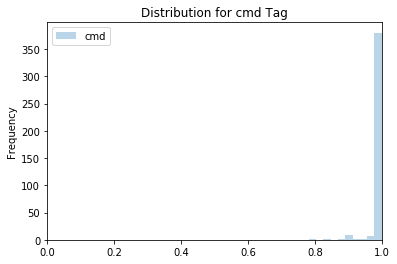

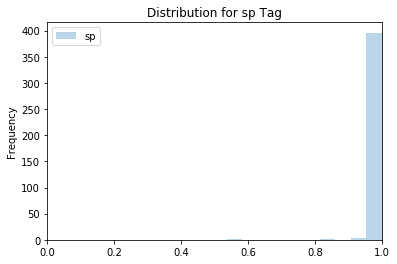

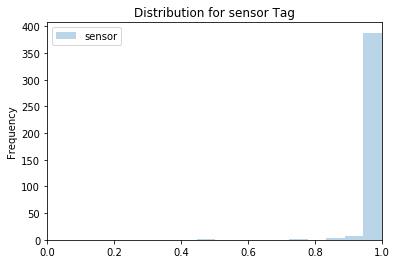

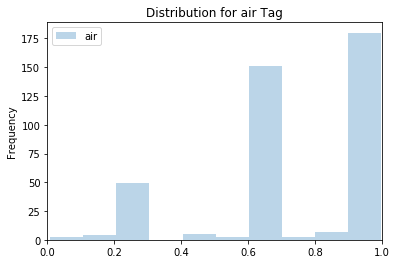

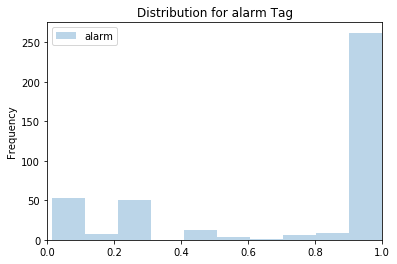

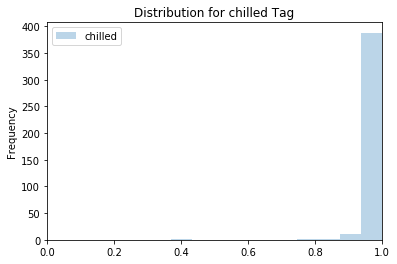

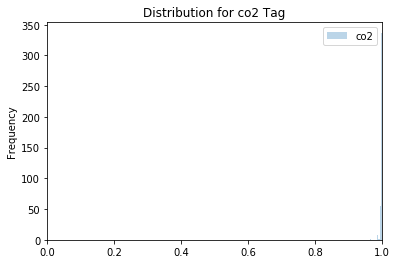

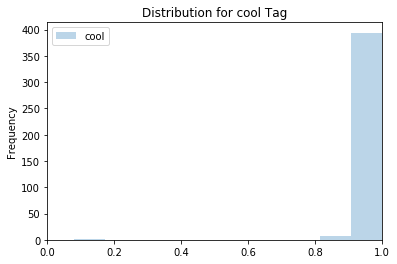

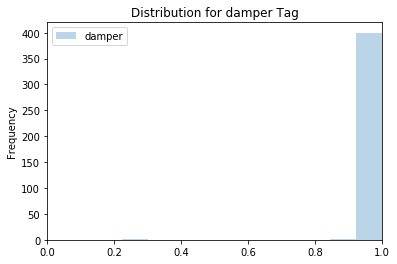

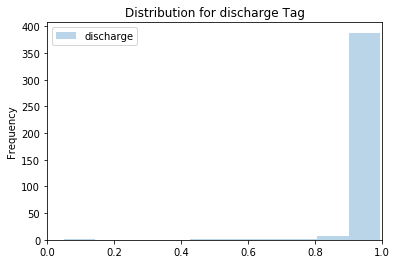

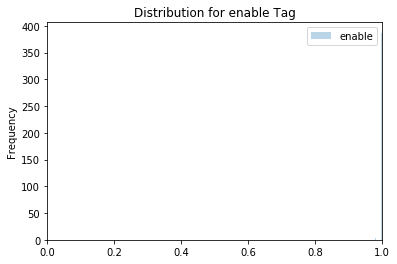

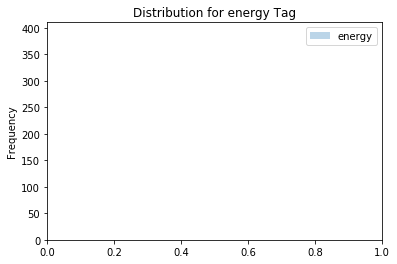

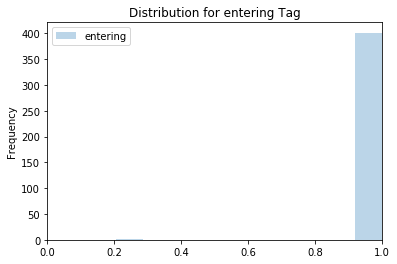

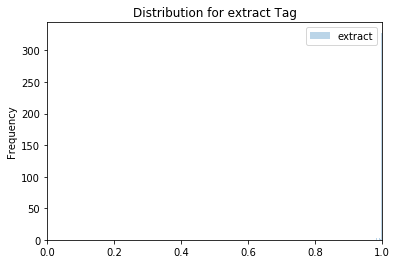

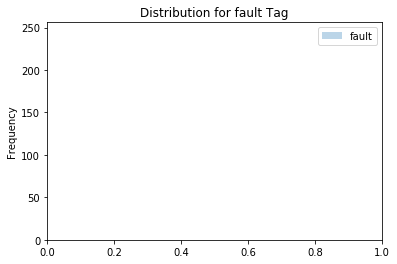

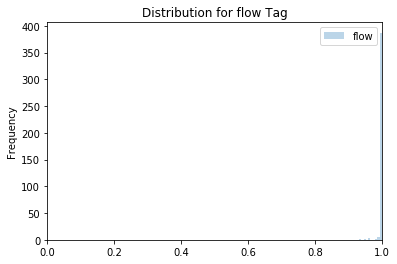

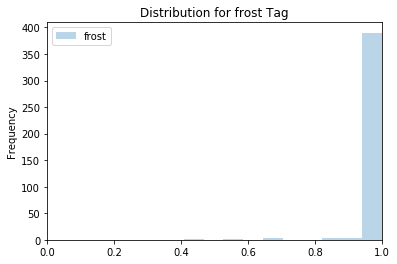

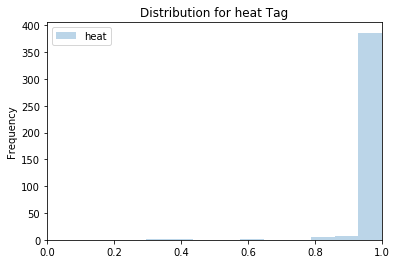

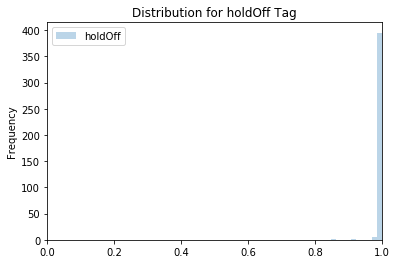

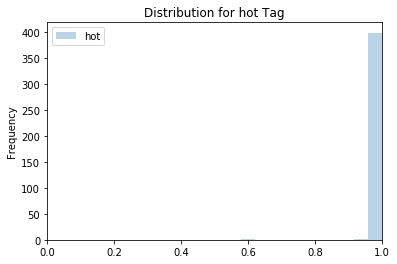

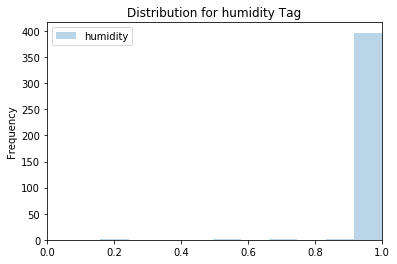

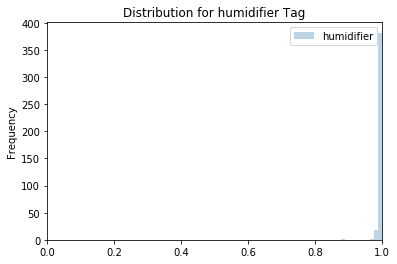

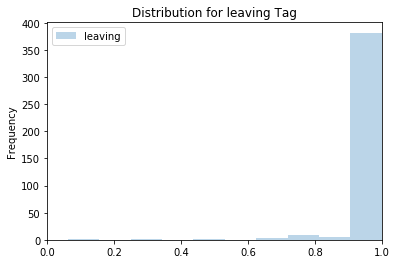

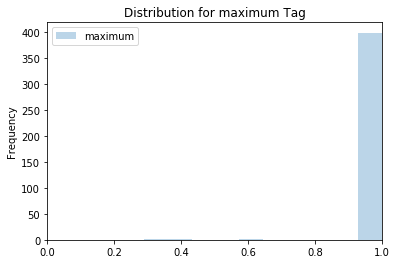

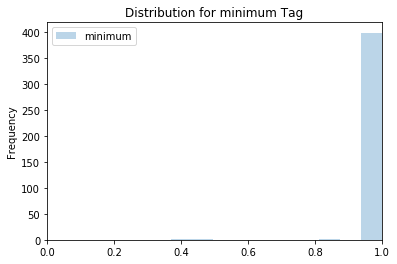

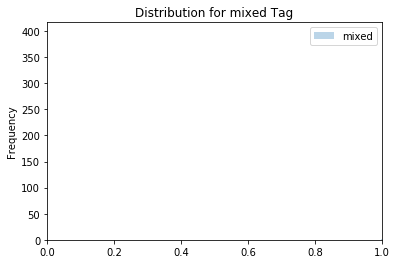

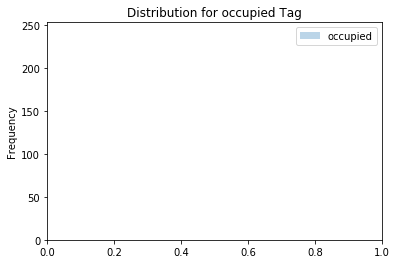

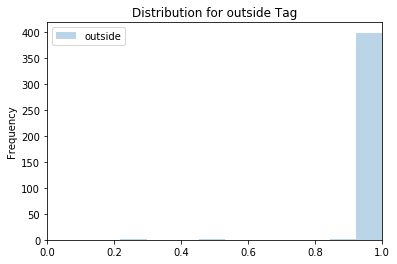

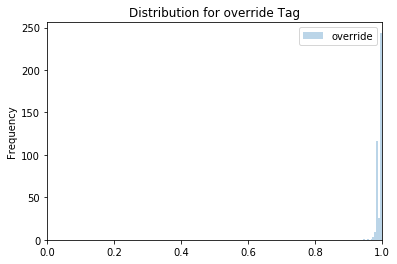

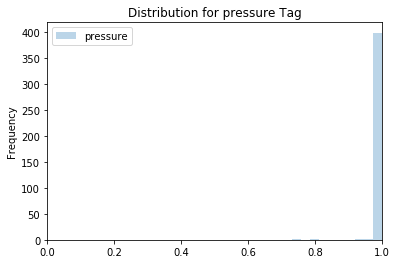

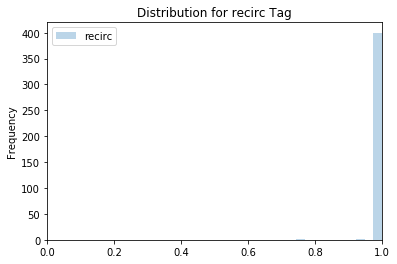

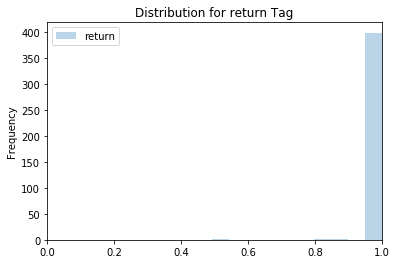

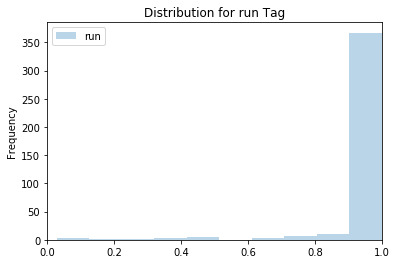

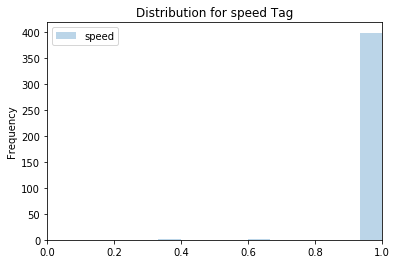

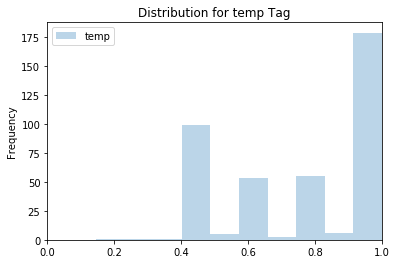

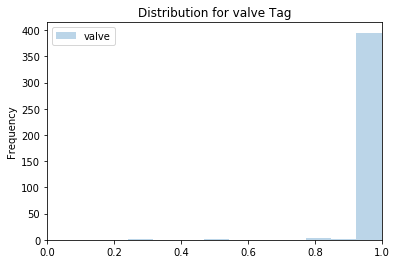

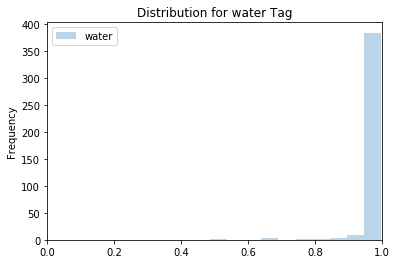

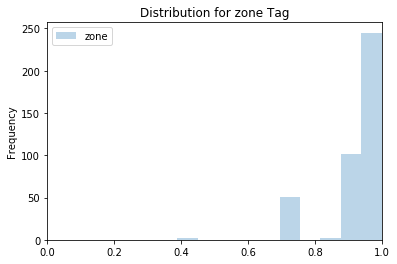

In [127]:
for category in list(confi_df):
    hist = confi_df[[category]].plot.hist(bins=10, alpha=0.3, title = "Distribution for " + category  + " Tag", xlim = (0,1))